
PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised learning?



For this, 

1. Build a standard dense autoencoder, visualize the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [7]:
from keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transforms such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [9]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [11]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottleneck layer with 2 as output size. 
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose a different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model 

In [14]:
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode1 = BatchNormalization()(encode1)
encode1 = Activation('relu')(encode1)
encode1 = Dropout(0.1)(encode1)
encode2 = Dense(64, activation='relu', name='encode2')(encode1)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)

bottleneck = Dense(2, activation=None, name='bottleneck')(encode3)

decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
decode1 = BatchNormalization()(decode1)
decode1 = Activation('relu')(decode1)
decode2 = Dense(64, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)


ae = models.Model(input_img, decode4)

ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode1 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode4 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,186 (871.82 KB)

 Trainable params: 222,866 (870.57 KB)

 Non-trainable params: 320 (1.25 KB)

In [15]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [17]:
from tensorflow.keras import optimizers

learning_rate = 3E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate))

In [18]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1426 - val_loss: 0.0702
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607 - val_loss: 0.0629
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580 - val_loss: 0.0596
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0561 - val_loss: 0.0580
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - val_loss: 0.0566
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543 - val_loss: 0.0567
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - val_loss: 0.0567
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527 - val_loss: 0.0552
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0521 - val_loss: 0.0540
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - val_loss: 0.0542
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514 - val_loss: 0.0535
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
ae.optimizer.learning_rate.assign(5e-4)

ae.compile(
    optimizer=ae.optimizer,
    loss='mean_squared_error'
)

fine_tune_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,               # stop if no improvement after 5 epochs
    restore_best_weights=True
)

history_finetune = ae.fit(
    x_tr, x_tr,
    validation_data=(x_val, x_val),
    batch_size=128,
    epochs=20,
    verbose=1
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402 - val_loss: 0.0395
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.0396
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.0395
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 - val_loss: 0.0394
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0394
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0390 - val_loss: 0.0394
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - val_loss: 0.0393
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - val_loss: 0.0396
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0393
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391 - val_loss: 0.0394
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.0393
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 - val_lo

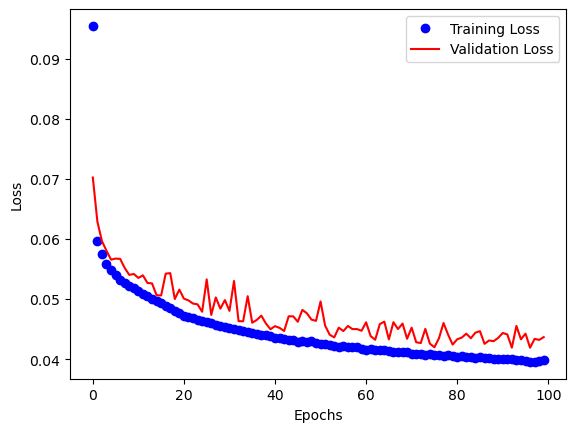

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


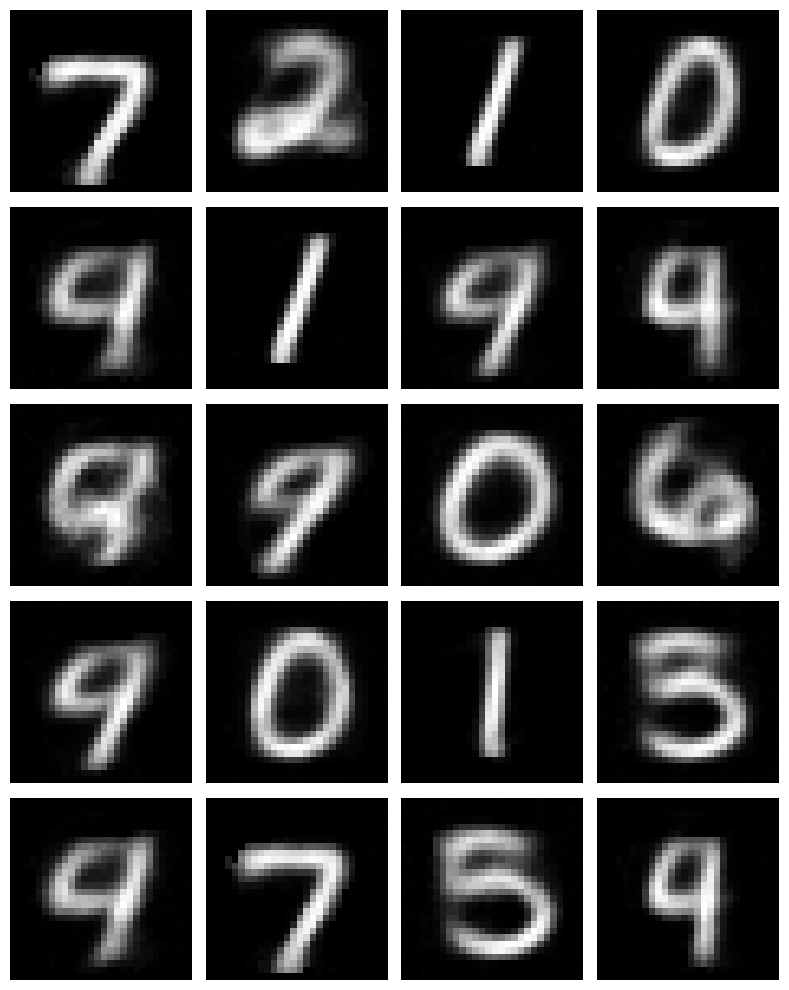

In [22]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [24]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.0396
loss = 0.039385441690683365


### 2.5. Visualize the low-dimensional features

In [26]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,394 (435.13 KB)

 Trainable params: 111,138 (434.13 KB)

 Non-trainable params: 256 (1.00 KB)

In [27]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
Shape of encoded_test: (10000, 2)


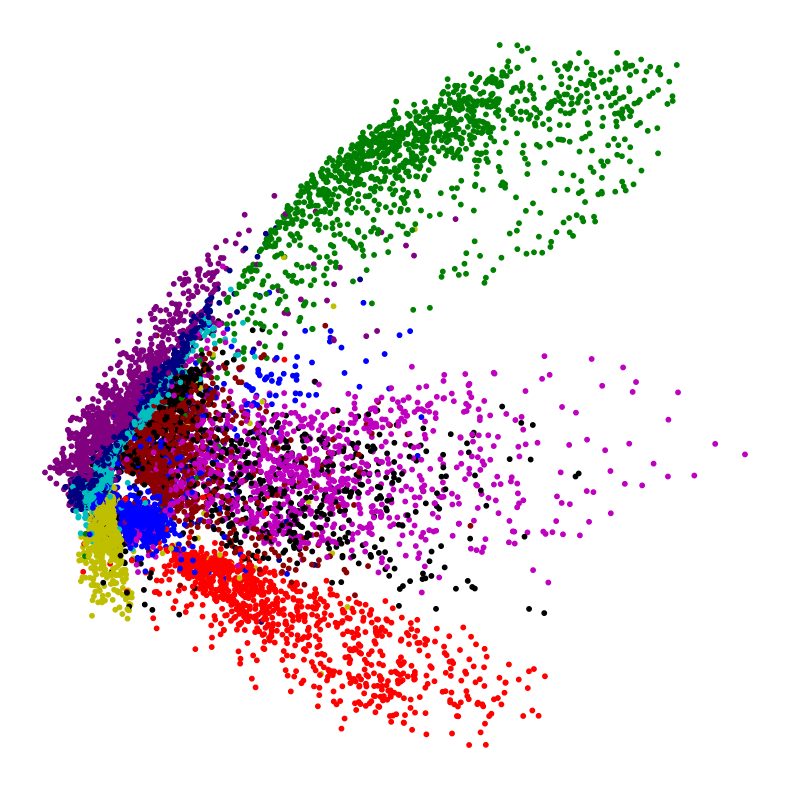

In [28]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantitatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? 

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [31]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [32]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,186 (71.04 KB)

 Trainable params: 18,186 (71.04 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - acc: 0.2541 - loss: 2.0600 - val_acc: 0.4805 - val_loss: 1.5880
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - acc: 0.5019 - loss: 1.5082 - val_acc: 0.5175 - val_loss: 1.3423
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - acc: 0.5482 - loss: 1.2828 - val_acc: 0.5832 - val_loss: 1.1898
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - acc: 0.5976 - loss: 1.1633 - val_acc: 0.6228 - val_loss: 1.1024
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - acc: 0.6407 - loss: 1.0942 - val_acc: 0.6452 - val_loss: 1.0450
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - acc: 0.6658 - loss: 1.0257 - val_acc: 0.6633 - val_loss: 1.0035
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - acc: 0.6739 - loss: 0.9909 - val_acc: 0.6742 - val_loss: 0.9704
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - acc: 0.6832 - loss: 0.9590 - val_acc: 0.6808 - val_loss: 0.9430
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


### 4.1. Build the network

In [37]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network

encode1 = Dense(128, activation=None, name='encode1')(input_img)
encode2 = Dense(64, activation='relu', name='encode2')(encode1)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.

bottleneck = Dense(2, activation=None, name='bottleneck')(encode3)

# decoder network
decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(64, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)


# build a classifier upon the bottleneck layer
classifier1 = Dense(32, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(32, activation='relu', name='classifier2')(classifier1)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)

In [38]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode1 (Dense)     │ (None, 128)       │    100,480 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode2 (Dense)     │ (None, 64)        │      8,256 │ encode1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode3 (Dense)     │ (None, 32)        │      2,080 │ encode2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 2)         │         66 │ encode3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode1 (Dense)     │ (None, 32)        │         96 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode2 (Dense)     │ (None, 64)        │      2,112 │ decode1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier1 (Dense) │ (None, 32)        │         96 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode3 (Dense)     │ (None, 128)       │      8,320 │ decode2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier2 (Dense) │ (None, 32)        │      1,056 │ classifier1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode4 (Dense)     │ (None, 784)       │    101,136 │ decode3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier3 (Dense) │ (None, 10)        │        330 │ classifier2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 224,028 (875.11 KB)

 Trainable params: 224,028 (875.11 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [41]:
from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(learning_rate=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - classifier3_loss: 1.5715 - decode4_loss: 0.1441 - loss: 0.9298 - val_classifier3_loss: 0.8872 - val_decode4_loss: 0.0632 - val_loss: 0.5070
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - classifier3_loss: 0.6405 - decode4_loss: 0.0620 - loss: 0.3822 - val_classifier3_loss: 0.5492 - val_decode4_loss: 0.0594 - val_loss: 0.3344
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - classifier3_loss: 0.4869 - decode4_loss: 0.0580 - loss: 0.3015 - val_classifier3_loss: 0.4553 - val_decode4_loss: 0.0566 - val_loss: 0.2845
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - classifier3_loss: 0.3675 - decode4_loss: 0.0561 - loss: 0.2399 - val_classifier3_loss: 0.4619 - val_decode4_loss: 0.0555 - val_loss: 0.2868
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - classifier3_loss: 0.2886 - decode4_loss: 0.0549 - loss: 0.1992 - val_classifier3_loss: 0.3941 - val_decode4_loss: 0.0546 - val_loss: 0.2519
Epoch 6/100
313/313 ━━━━━

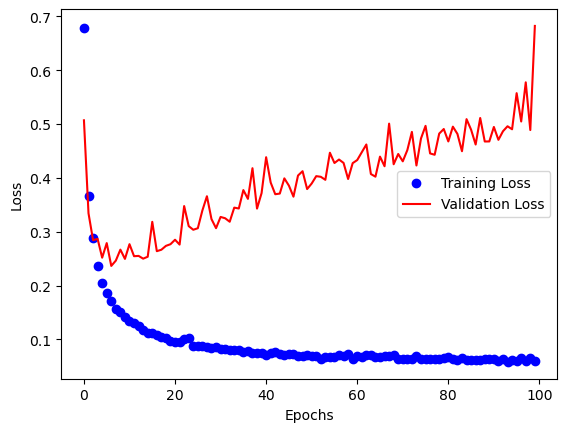

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

Model: "supervised_AE_reg"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode1 (Dense)     │ (None, 128)       │    100,480 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 128)       │        512 │ encode1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act1 (Activation)   │ (None, 128)       │          0 │ bn1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 128)       │          0 │ act1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode2 (Dense)     │ (None, 64)        │      8,256 │ drop1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 64)        │        256 │ encode2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act2 (Activation)   │ (None, 64)        │          0 │ bn2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 64)        │          0 │ act2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode3 (Dense)     │ (None, 32)        │      2,080 │ drop2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 32)        │        128 │ encode3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act3 (Activation)   │ (None, 32)        │          0 │ bn3[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop3 (Dropout)     │ (None, 32)        │          0 │ act3[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 2)         │         66 │ drop3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier1 (Dense) │ (None, 32)        │         96 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ classifier1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode1 (Dense)     │ (None, 32)        │         96 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clf_drop1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode2 (Dense)     │ (None, 64)        │      2,112 │ decode1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier2 (Dense) │ (None, 32)        │      1,056 │ clf_drop1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode3 (Dense)     │ (None, 128)       │      8,320 │ decode2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clf_drop2 (Dropout) │ (None, 32)        │          0 │ classifier2[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 225,052 (879.11 KB)

 Trainable params: 224,540 (877.11 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - classifier3_loss: 2.0767 - decode4_loss: 0.1420 - loss: 1.2186 - val_classifier3_loss: 1.0092 - val_decode4_loss: 0.0655 - val_loss: 0.6075
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - classifier3_loss: 1.1838 - decode4_loss: 0.0649 - loss: 0.6936 - val_classifier3_loss: 0.7085 - val_decode4_loss: 0.0611 - val_loss: 0.4516
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - classifier3_loss: 0.9623 - decode4_loss: 0.0617 - loss: 0.5785 - val_classifier3_loss: 0.5887 - val_decode4_loss: 0.0586 - val_loss: 0.3884
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - classifier3_loss: 0.8896 - decode4_loss: 0.0598 - loss: 0.5397 - val_classifier3_loss: 0.5213 - val_decode4_loss: 0.0574 - val_loss: 0.3532
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - classifier3_loss: 0.8023 - decode4_loss: 0.0582 - loss: 0.4942 - val_classifier3_loss: 0.5194 - val_decode4_loss: 0.0564 - val_loss: 0.3513
Epoch 6/100
313/313 ━━━━━

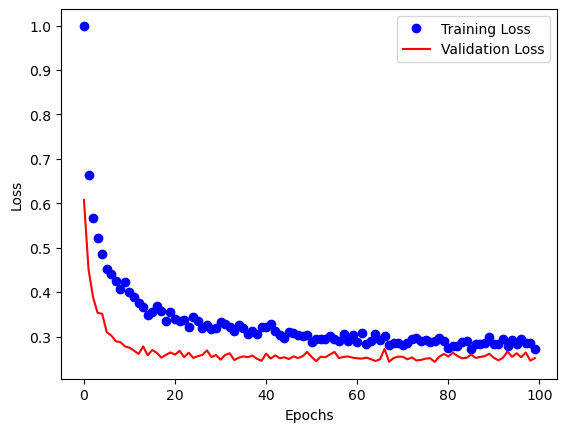

In [44]:
from keras import models, regularizers
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation

#Input
input_img = Input(shape=(784,), name='input_img')

#Encoder with Dropout + BatchNorm + L2
encode1 = Dense(128,
                activation=None,
                kernel_regularizer=regularizers.l2(1e-4),
                name='encode1')(input_img)
bn1     = BatchNormalization(name='bn1')(encode1)
act1    = Activation('relu', name='act1')(bn1)
drop1   = Dropout(0.2, name='drop1')(act1)

encode2 = Dense(64,
                activation=None,
                kernel_regularizer=regularizers.l2(1e-4),
                name='encode2')(drop1)
bn2     = BatchNormalization(name='bn2')(encode2)
act2    = Activation('relu', name='act2')(bn2)
drop2   = Dropout(0.2, name='drop2')(act2)

encode3 = Dense(32,
                activation=None,
                kernel_regularizer=regularizers.l2(1e-4),
                name='encode3')(drop2)
bn3     = BatchNormalization(name='bn3')(encode3)
act3    = Activation('relu', name='act3')(bn3)
drop3   = Dropout(0.3, name='drop3')(act3)

#Bottleneck (2-dim)
bottleneck = Dense(2,
                   activation=None,
                   kernel_regularizer=regularizers.l2(1e-4),
                   name='bottleneck')(drop3)

#Decoder
decode1 = Dense(32,  activation='relu', name='decode1')(bottleneck)
decode2 = Dense(64,  activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)

#Classification head with Dropout + L2
clf1 = Dense(32,
             activation='relu',
             kernel_regularizer=regularizers.l2(1e-4),
             name='classifier1')(bottleneck)
clf1 = BatchNormalization()(clf1)
clf1 = Dropout(0.2, name='clf_drop1')(clf1)

clf2 = Dense(32,
             activation='relu',
             kernel_regularizer=regularizers.l2(1e-4),
             name='classifier2')(clf1)
clf2 = Dropout(0.2, name='clf_drop2')(clf2)

classifier3 = Dense(10,
                    activation='softmax',
                    name='classifier3')(clf2)

#Build the multi‐output supervised AE
sae = models.Model(
    inputs = input_img,
    outputs= [decode4, classifier3],
    name   = 'supervised_AE_reg'
)

sae.summary()

from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(learning_rate=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.3. Visualize the reconstructed test images

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


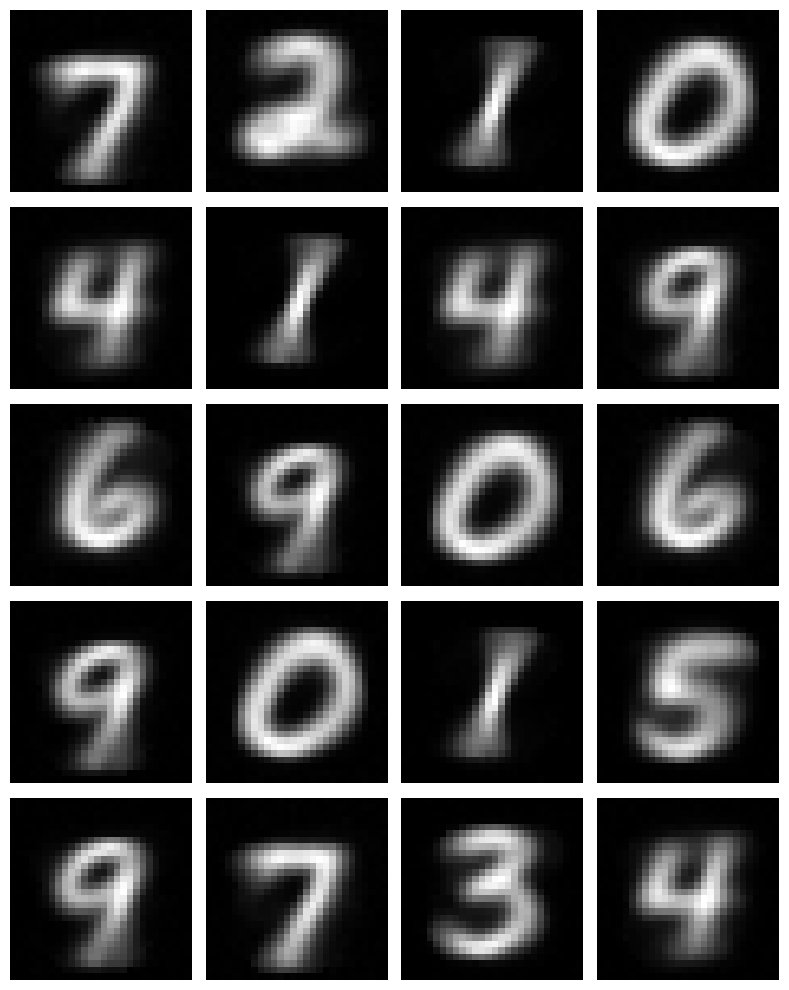

In [46]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features



In [48]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3 (Activation)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,778 (436.63 KB)

 Trainable params: 111,330 (434.88 KB)

 Non-trainable params: 448 (1.75 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
Shape of encoded_test: (10000, 2)


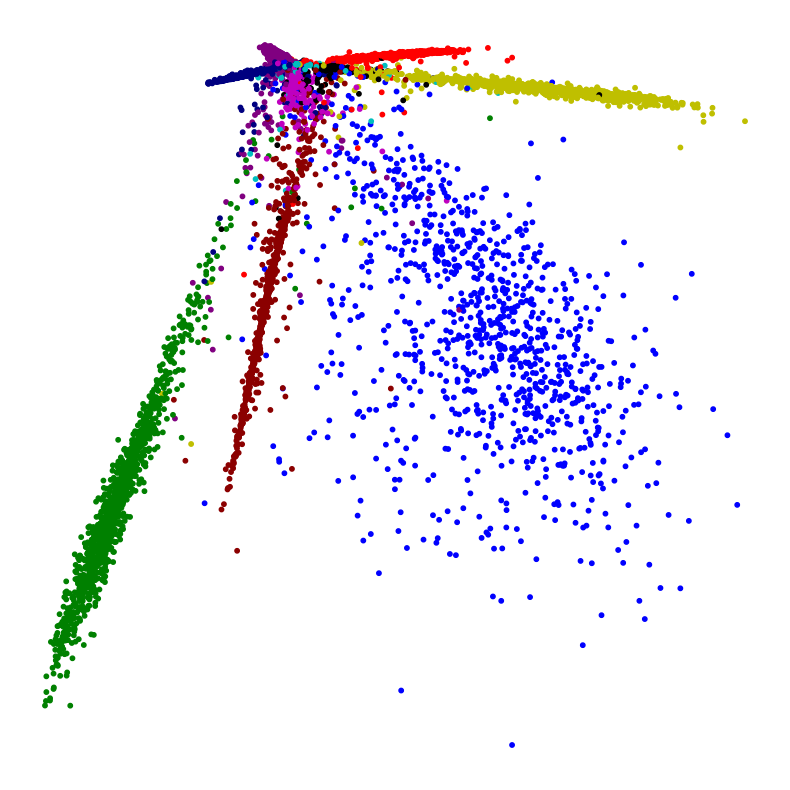

In [49]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? 

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [51]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


In [52]:
# build a classifier which takes the 2D features as input
from keras.layers import *
from keras import models

input_feat = Input(shape=(2,))

# <build a classifier which takes input_feat as input>
# output = <output of the classifier network>

input = Dense(128, activation='relu')(input_feat)
input = Dense(128, activation='relu')(input)

output = Dense(10, activation='softmax')(input)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,186 (71.04 KB)

 Trainable params: 18,186 (71.04 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - acc: 0.3220 - loss: 1.8535 - val_acc: 0.6711 - val_loss: 1.3335
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - acc: 0.7892 - loss: 1.1413 - val_acc: 0.8579 - val_loss: 0.9419
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - acc: 0.9268 - loss: 0.7465 - val_acc: 0.9352 - val_loss: 0.6558
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - acc: 0.9835 - loss: 0.4496 - val_acc: 0.9311 - val_loss: 0.4735
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - acc: 0.9804 - loss: 0.2581 - val_acc: 0.9288 - val_loss: 0.3926
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - acc: 0.9834 - loss: 0.1584 - val_acc: 0.9278 - val_loss: 0.3759
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - acc: 0.9789 - loss: 0.1389 - val_acc: 0.9314 - val_loss: 0.3718
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - acc: 0.9831 - loss: 0.1043 - val_acc: 0.9322 - val_loss: 0.3734
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [55]:
# evaluate your model on the never-seen-before test data
# write your code here:
_, test_acc_s = classifier.evaluate(f_te, y_test_vec, verbose=0)
print(f"Test accuracy using Supervised AE features: {test_acc_s:.4f}")

Test accuracy using Supervised AE features: 0.9432
